In [ ]:
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

Notebook last run (end-to-end): 2023-11-23 23:41:08.851765


In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-28164fbd-45a2-11dd-ad77-a74f128337ba)


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 38.76 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [ ]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


Working with the whole 200k dataset.

In [ ]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/"

Unzip 'train.zip'

In [ ]:
import zipfile


# Unzip the downloaded file
zip_ref = zipfile.ZipFile(data_dir+'train.zip', "r")
zip_ref.extractall(path=data_dir)
zip_ref.close()

In [ ]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/train.zip',
 'pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/test.txt']

Data Preprocessing

In [ ]:
#Create function to read lines

def get_lines(filename):
  '''
  Reads filename and returns the lines of text as a list.

  Args:
  ----
    A string containing the target filepath to read.

  Returns:
    A list of strings with one string per line from the target filepath.
    For Eaxmple:
      ['This is first line of the filepath',
       'This is second line of the filepath',
       .....]
  '''
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir + 'train.txt')
train_lines[:15]

['###24491034\n',
 'BACKGROUND\tThe emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .\n',
 'BACKGROUND\tThis paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .\n',
 'METHODS\tThis study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .\n',
 "METHODS\tThe intervention group will participate in the online group program ` Positive Outlook ' .\n",
 'METHODS\tThe program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .\n',
 'METHODS\tParticipants will access the program f

In [ ]:
def preprocess_text_with_line_numbers(filename):
  '''
  Returning a list of dictionaries of abstract line data.

  Takes in filename, read its contents and sorts thorugh each line.
  extracting things like target labels, texts of the sentences.
  How many sentences are in the current abstract and what sentence number the target line is.


  Arg:
    The string containing target text filepath to read texts and extarct line data from.


  Returns:
    An list of dictionries each containing a line from an abstract.
    The line label, line position at the abstract and total
    number of lines in the abstract where the line is from.

    For Example:
      [{target: OBJECTIVE,
        text: this is the text.
        line_number: 2,
        total_lines: 5}]

  '''

  input_lines = get_lines(filename)
  abstract_lines = ''
  abstract_sample = []

  # Loop through each line of target files.
  for line in input_lines:
    if line.startswith('###'): #Check to see the line is an ID line.
      abstract_ID = line
      abstract_lines = '' # reset abstract string.
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() #split abstract into sperate lines.


      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #create a dict to store abstract line data
        target_text_split = abstract_line.split('\t')
        line_data['target'] = target_text_split[0]
        line_data['text'] = target_text_split[1]
        line_data['line_number'] = abstract_line_number
        line_data['total_line'] = len(abstract_line_split)-1
        abstract_sample.append(line_data)

    else:
      abstract_lines += line

  return abstract_sample


In [ ]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 6.18 s, sys: 1.05 s, total: 7.23 s
Wall time: 16.4 s


(2211861, 28932, 29493)

In [ ]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'BACKGROUND',
  'text': 'The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
  'line_number': 0,
  'total_line': 10},
 {'target': 'BACKGROUND',
  'text': 'This paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .',
  'line_number': 1,
  'total_line': 10},
 {'target': 'METHODS',
  'text': 'This study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .',
  'line_number': 2,
  'total_line': 10},
 {'target': 'METHODS',
  'text': "The intervention group will participate in the online group program ` Positive Outlook ' .",
  'line_number': 3,
  'total_line': 10},
 {'target': 'METHODS',
  'text

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(24)

,target,text,line_number,total_line
0,BACKGROUND,The emergence of HIV as a chronic condition me...,0,10
1,BACKGROUND,This paper describes the design and evaluation...,1,10
2,METHODS,This study is designed as a randomised control...,2,10
3,METHODS,The intervention group will participate in the...,3,10
4,METHODS,The program is based on self-efficacy theory a...,4,10
5,METHODS,Participants will access the program for a min...,5,10
6,METHODS,Primary outcomes are domain specific self-effi...,6,10
7,METHODS,"Secondary outcomes include : depression , anxi...",7,10
8,METHODS,"Data collection will take place at baseline , ...",8,10
9,CONCLUSIONS,Results of the Positive Outlook study will pro...,9,10


In [ ]:
# Distribution of labels in training data
train_df.target.value_counts()

RESULTS        766271
METHODS        722586
CONCLUSIONS    339714
BACKGROUND     196689
OBJECTIVE      186601
Name: target, dtype: int64

<Axes: >

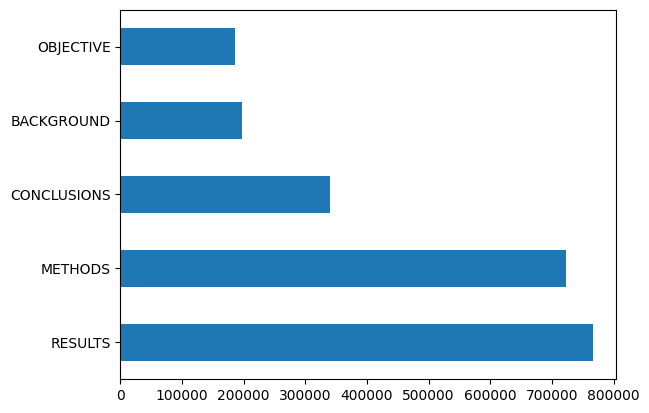

In [ ]:
train_df.target.value_counts().plot.barh()

<Axes: >

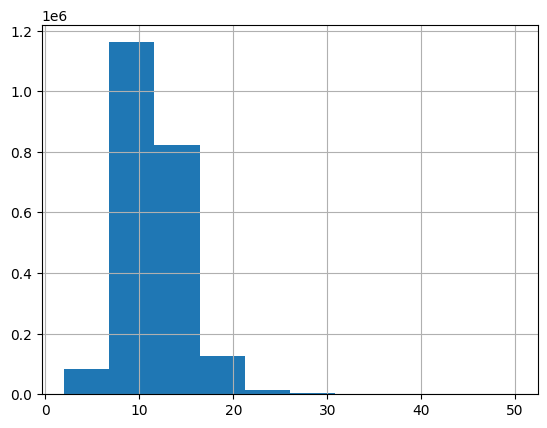

In [ ]:
train_df.total_line.hist()

In [ ]:
# Convert abstract lines into list
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

In [ ]:
train_sentences[:10]

['The emergence of HIV as a chronic condition means that people living with HIV are required to take more responsibility for the self-management of their condition , including making physical , emotional and social adjustments .',
 'This paper describes the design and evaluation of Positive Outlook , an online program aiming to enhance the self-management skills of gay men living with HIV .',
 'This study is designed as a randomised controlled trial in which men living with HIV in Australia will be assigned to either an intervention group or usual care control group .',
 "The intervention group will participate in the online group program ` Positive Outlook ' .",
 'The program is based on self-efficacy theory and uses a self-management approach to enhance skills , confidence and abilities to manage the psychosocial issues associated with HIV in daily life .',
 'Participants will access the program for a minimum of @ minutes per week over seven weeks .',
 'Primary outcomes are domain sp

Make numeric labels

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [ ]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([0, 0, 2, ..., 4, 4, 4])

In [ ]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names


(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))



```
`# This is formatted as code`
```

Model 0: Getting a baseline

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);

In [ ]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7497580533665146

In [ ]:
# Function to evaluate: accuracy, precision, recall, f1-score

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  '''
  Calculate model accuracy, precision, recall and f1-score of a classification model.

  Args:
    y_true: true labels in the form of 1D array.
    y_pred: predicted labels in the form of 1D array.

  Returns:
    It's returns a dictionary of model accuracy, precision,
    recall, f1_score.

  '''

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([0, 4, 4, ..., 4, 4, 1])

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 74.97580533665146,
 'precision': 0.7431966265737352,
 'recall': 0.7497580533665146,
 'f1': 0.7389570175489825}

Preparing Data for Deep Sequence model.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# How long is each sentance on avarage?
sen_len = [len(sentence.split()) for sentence in train_sentences]
ave_sen_len = np.mean(sen_len)
ave_sen_len


26.229355280462922

(array([1.730629e+06, 4.400640e+05, 3.549300e+04, 4.499000e+03,
        8.570000e+02, 2.060000e+02, 7.600000e+01, 2.500000e+01,
        9.000000e+00, 3.000000e+00]),
 array([  1. ,  34.7,  68.4, 102.1, 135.8, 169.5, 203.2, 236.9, 270.6,
        304.3, 338. ]),
 <BarContainer object of 10 artists>)

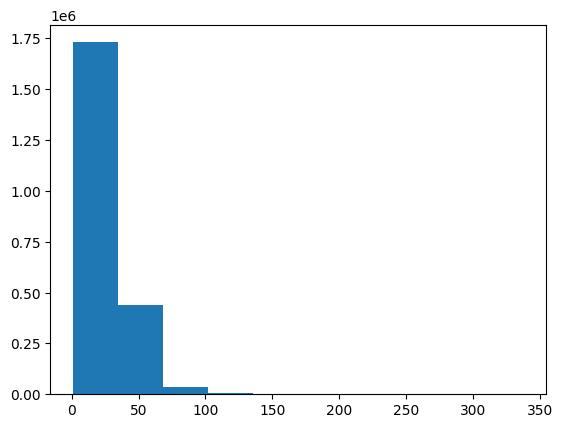

In [ ]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sen_len)

In [ ]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sen_len, 95))
output_seq_len

54

In [ ]:
max(sen_len)

338

In [ ]:
min(sen_len)

1

Create text vectorizer

In [ ]:
# How many words are in our vocabulary? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf) ** for 200k dataset
max_tokens = 331000

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_sentences)


In [ ]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=54)

In [ ]:
# Adapt text vectorizer to train_sentences
text_vectorizer.adapt(train_dataset.batch(32))

In [ ]:
# Test out our text_vectorizer
import random
target_sentence = random.choice(train_sentences)
vectorize_sen = text_vectorizer(target_sentence)
print(f'Text: {target_sentence} \n {len(target_sentence.split())}')
print(f'Vectorized text: {vectorize_sen}')

Text: The mediating effects on problematic drinking were significantly greater for men than women . 
 14
Vectorized text: [   2 7061   58   19 6992 1266    9   34  164   12  260   36   72    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [ ]:
# How many words in training vocabulary
rct_200k_vocab = text_vectorizer.get_vocabulary()
print(f'Length of vocabulary: {len(rct_200k_vocab)}')
print(f'Most common words: {rct_200k_vocab[:5]}')
print(f'Least common words: {rct_200k_vocab[-5:]}')

Length of vocabulary: 247961
Most common words: ['', '[UNK]', 'the', 'of', 'and']
Least common words: ['aaae', 'aaacp', 'aaabbb', 'aaaanalog', 'aaaa']


In [ ]:
# Get configuration of our text_vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 331000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 54,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 247961}

Create custom text embedding

In [ ]:
# Create token embedding layer.
token_embedding = layers.Embedding(input_dim=len(rct_200k_vocab),
                                   output_dim=128,
                                   mask_zero=True,
                                   name='Token_Embedding')

# show an example of embedding.
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embedding(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
The mediating effects on problematic drinking were significantly greater for men than women .

Sentence after vectorization (before embedding):
[[   2 7061   58   19 6992 1266    9   34  164   12  260   36   72    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
[[[ 0.03235618  0.02345464  0.01542299 ... -0.03198518  0.04077708
    0.04646938]
  [ 0.0161295   0.03223162  0.00309939 ...  0.00022135  0.02977045
   -0.01839511]
  [-0.0086568  -0.04185201  0.0150899  ... -0.04031242  0.04169425
    0.00289049]
  ...
  [-0.03847776  0.04057683 -0.02513524 ...  0.0069985  -0.00242922
   -0.04044815]
  [-0.03847776  0.04057683 -0.02513524 ...  0.0069985  -0.00242922
   -0.04044815]
  [-0.03847776  0.04057683 -0.02513524 ...  0.0069985  -0.00242922
   -0.04044815]]]

Embedded se

Create Datasets

In [ ]:
# Turn our data into tensorflow dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
# Take the TensorSliceDataset and turn them into prefatched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

Model 1: Conv1D with token embeddings

In [ ]:
# Create Conv1D model
inputs = layers.Input(shape=(1, ), dtype=tf.string)
text_vector = text_vectorizer(inputs)
embedding = token_embedding(text_vector)
x = layers.Conv1D(64, kernel_size=5, activation='relu')(embedding)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

In [ ]:
# Compile the Model
model_1.compile(loss='categorical_crossentropy', #Because of labels are one hot encoded
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy']
                )

In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 54)                0         
 ctorization)                                                    
                                                                 
 Token_Embedding (Embedding  (None, 54, 128)           31739008  
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 50, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=len(train_dataset),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=len(valid_dataset))

Epoch 1/3
69121/69121 [==============================] - 829s 12ms/step - loss: 0.4744 - accuracy: 0.8314 - val_loss: 0.4164 - val_accuracy: 0.8516
Epoch 2/3
69121/69121 [==============================] - 787s 11ms/step - loss: 0.4028 - accuracy: 0.8578 - val_loss: 0.4085 - val_accuracy: 0.8542
Epoch 3/3
69121/69121 [==============================] - 785s 11ms/step - loss: 0.3616 - accuracy: 0.8732 - val_loss: 0.4217 - val_accuracy: 0.8517


In [ ]:
# Make predictions (our model outputs prediction probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

905/905 [==============================] - 2s 2ms/step


array([[8.4218746e-01, 2.2248829e-05, 9.2597494e-09, 1.5779029e-01,
        9.4461106e-09],
       [1.9108165e-02, 3.3544316e-03, 8.2594758e-01, 2.9628215e-02,
        1.2196158e-01],
       [2.3613948e-05, 6.5612800e-02, 1.0153826e-04, 3.9475249e-06,
        9.3425810e-01],
       ...,
       [3.7296602e-05, 5.5251229e-01, 5.2167172e-07, 5.0620856e-06,
        4.4744489e-01],
       [2.3689461e-03, 7.2613949e-01, 4.7864864e-04, 6.5745314e-04,
        2.7035540e-01],
       [7.2030656e-02, 9.0474963e-01, 7.3759889e-05, 1.8243833e-02,
        4.9021207e-03]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 1, 1, 1])>

In [ ]:
# Calculate model_1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 85.16867136734412,
 'precision': 0.8513264320087761,
 'recall': 0.8516867136734412,
 'f1': 0.8503838502062798}

Model 2: Feature extraction with pretrained token embeddings

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
Both groups were reassessed after @ months .

Sentence after embedding:
[-0.00535453 -0.05520891  0.00665603  0.05211029 -0.0786868   0.02566805
 -0.00100029 -0.05661223 -0.10917892 -0.00791329  0.00290073 -0.01392669
 -0.00401322 -0.07309151 -0.02979317  0.00116219 -0.02411642 -0.08263157
 -0.01658888  0.02049628  0.00035813  0.05390036 -0.07381359 -0.04284087
 -0.00572881  0.02954646 -0.00474318  0.08554717  0.01196597  0.04171269] (truncated output)...

Length of sentence embedding:
512


In [ ]:
# Define feature extractor model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(5, activation="softmax")(x) # create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the model
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
# Fit feature extractor model for 3 epochs
model_2.fit(train_dataset,
            steps_per_epoch=len(train_dataset),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=len(valid_dataset))

Epoch 1/3
69121/69121 [==============================] - 885s 13ms/step - loss: 0.5922 - accuracy: 0.7773 - val_loss: 0.5583 - val_accuracy: 0.7893
Epoch 2/3
69121/69121 [==============================] - 876s 13ms/step - loss: 0.5526 - accuracy: 0.7934 - val_loss: 0.5470 - val_accuracy: 0.7932
Epoch 3/3
69121/69121 [==============================] - 872s 13ms/step - loss: 0.5430 - accuracy: 0.7973 - val_loss: 0.5428 - val_accuracy: 0.7960


In [ ]:
# Evaluate on whole validation dataset
model_2.evaluate(valid_dataset)


905/905 [==============================] - 10s 11ms/step - loss: 0.5428 - accuracy: 0.7960


[0.5428207516670227, 0.7960044145584106]

In [ ]:
# Make predictions with feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

905/905 [==============================] - 10s 11ms/step


array([[1.11718126e-01, 5.63953161e-01, 1.26906514e-01, 4.35193107e-02,
        1.53902978e-01],
       [5.75967617e-02, 6.59838170e-02, 7.15069532e-01, 7.44349435e-02,
        8.69149193e-02],
       [6.59083424e-04, 1.90022334e-01, 1.79817844e-02, 3.34426033e-04,
        7.91002393e-01],
       ...,
       [8.99804663e-03, 6.88996136e-01, 2.19363160e-03, 3.25989421e-03,
        2.96552330e-01],
       [5.22395968e-02, 3.91647398e-01, 1.26906231e-01, 2.95167398e-02,
        3.99690002e-01],
       [3.40224952e-01, 2.77172148e-01, 3.69274669e-04, 3.80622864e-01,
        1.61077047e-03]], dtype=float32)

In [ ]:
# Convert the predictions with feature extraction model to classes
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([1, 2, 4, ..., 1, 4, 3])>

In [ ]:
# Calculate results from TF Hub pretrained embeddings results on validation set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 79.60044241670123,
 'precision': 0.7957477378084195,
 'recall': 0.7960044241670123,
 'f1': 0.7938333891592622}


Model 3: Conv1D with character embeddings


In [ ]:
# make function to split sentences into characters.
def split_chars(text):
  return ' '.join(list(text))

# test split_chars function.
split_chars(random_training_sentence)

'B o t h   g r o u p s   w e r e   r e a s s e s s e d   a f t e r   @   m o n t h s   .'

In [ ]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])


T h e   e m e r g e n c e   o f   H I V   a s   a   c h r o n i c   c o n d i t i o n   m e a n s   t h a t   p e o p l e   l i v i n g   w i t h   H I V   a r e   r e q u i r e d   t o   t a k e   m o r e   r e s p o n s i b i l i t y   f o r   t h e   s e l f - m a n a g e m e n t   o f   t h e i r   c o n d i t i o n   ,   i n c l u d i n g   m a k i n g   p h y s i c a l   ,   e m o t i o n a l   a n d   s o c i a l   a d j u s t m e n t s   .


In [ ]:
len(train_chars)

2211861

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

147.82646377869133

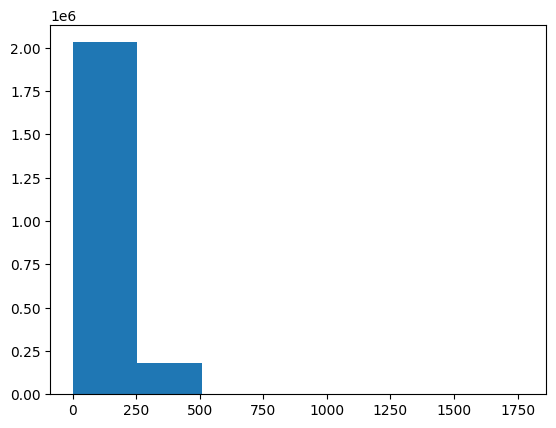

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

284

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
train_chars_batch = tf.data.Dataset.from_tensor_slices(train_chars)


In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars_batch.batch(32))

In [ ]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'a']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
T h e   h y p o t h e s i s   i s   t h a t   e x p o s u r e   t o   (   t a i l o r e d   )   P D S   w i l l   r e s u l t   i n   g r e a t e r   p a r t i c i p a t i o n   i n   s c r e e n i n g   t h a n   p a r t i c i p a t i o n   f o l l o w i n g   e x p o s u r e   t o   n o n - t a i l o r e d   P D S   o r   r e s u l t i n g   f r o m   t h e   c u r r e n t   n o n - t a i l o r e d   ,   p a p e r - b a s e d   a p p r o a c h   .

Length of chars: 194

Vectorized chars:
[[ 3 13  2 13 19 14  7  3 13  2  9  5  9  5  9  3 13  4  3  2 24 14  7  9
  16  8  2  3  7  3  4  5 11  7  8  2 10 14 10  9 20  5 11 11  8  2  9 16
  11  3  5  6 18  8  2  4  3  2  8 14  4  8  3  5 12  5 14  4  3  5  7  6
   5  6  9 12  8  2  2  6  5  6 18  3 13  4  6 14  4  8  3  5 12  5 14  4
   3  5  7  6 17  7 11 11  7 20  5  6 18  2 24 14  7  9 16  8  2  3  7  6
   7  6  3  4  5 11  7  8  2 10 14 10  9  7  8  8  2  9 16 11  3  5  6 18
  17  8  7 15  3 13  2 12 16  8  8  2  6  3  

Creating a character-level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
T h e   h y p o t h e s i s   i s   t h a t   e x p o s u r e   t o   (   t a i l o r e d   )   P D S   w i l l   r e s u l t   i n   g r e a t e r   p a r t i c i p a t i o n   i n   s c r e e n i n g   t h a n   p a r t i c i p a t i o n   f o l l o w i n g   e x p o s u r e   t o   n o n - t a i l o r e d   P D S   o r   r e s u l t i n g   f r o m   t h e   c u r r e n t   n o n - t a i l o r e d   ,   p a p e r - b a s e d   a p p r o a c h   .

Embedded chars (after vectorization and embedding):
[[[-0.04981453  0.01224599 -0.04226747 ...  0.00096449 -0.03244605
    0.04074675]
  [-0.01759039 -0.03347296 -0.02450032 ...  0.0325142   0.04181356
   -0.04493641]
  [-0.01099445 -0.01025395 -0.0113226  ... -0.04441495 -0.03626487
   -0.04067942]
  ...
  [ 0.02475608  0.0257063   0.00549995 ... -0.0389101  -0.04064794
    0.02340377]
  [ 0.02475608  0.0257063   0.00549995 ... -0.0389101  -0.04064794
    0.02340377]
  [ 0.02475608  0.0

Building a Conv1D model to fit on character embeddings

In [ ]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Check the summary of conv1d_char_model
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 284)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 284, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 284, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

In [ ]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=len(train_char_dataset),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=len(val_char_dataset))

Epoch 1/3
69121/69121 [==============================] - 368s 5ms/step - loss: 0.6932 - accuracy: 0.7397 - val_loss: 0.6060 - val_accuracy: 0.7751
Epoch 2/3
69121/69121 [==============================] - 369s 5ms/step - loss: 0.6181 - accuracy: 0.7708 - val_loss: 0.5930 - val_accuracy: 0.7805
Epoch 3/3
69121/69121 [==============================] - 369s 5ms/step - loss: 0.6068 - accuracy: 0.7754 - val_loss: 0.5886 - val_accuracy: 0.7823


In [ ]:
# Evaluate model_3 on whole validation char dataset
model_3.evaluate(val_char_dataset)

905/905 [==============================] - 4s 4ms/step - loss: 0.5886 - accuracy: 0.7823


[0.5886108875274658, 0.7823171615600586]

In [ ]:
# Make predictions with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

905/905 [==============================] - 3s 3ms/step


array([[4.8388511e-01, 2.7494454e-01, 1.3254122e-02, 2.0547065e-01,
        2.2445638e-02],
       [1.9505904e-03, 7.5247125e-03, 8.7240094e-01, 1.2917107e-03,
        1.1683208e-01],
       [7.3887501e-04, 4.2994048e-02, 3.9543316e-02, 5.1611458e-04,
        9.1620761e-01],
       ...,
       [9.7568762e-03, 5.3726786e-01, 2.9874512e-03, 5.5615865e-03,
        4.4442621e-01],
       [3.6677722e-02, 4.8511121e-01, 5.9085004e-03, 1.8424768e-02,
        4.5387778e-01],
       [2.8030860e-01, 6.1460805e-01, 7.5399564e-03, 9.2079662e-02,
        5.4637995e-03]], dtype=float32)

In [ ]:
# Convert predictions to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 1, 1, 1])>

In [ ]:
# Calculate Conv1D char only model results
model_3_results = calculate_results(y_true=val_labels_encoded,
                                        y_pred=model_3_preds)
model_3_results


{'accuracy': 78.23171574726946,
 'precision': 0.7858725827098436,
 'recall': 0.7823171574726946,
 'f1': 0.7801257894517589}

Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

In [ ]:
# 1. setup token input model.
token_inputs = layers.Input(shape=[], dtype=tf.string, name='token_input')
token_embedding = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embedding)
token_model = tf.keras.Model(token_inputs, token_outputs, name='token_model')


# 2. setup chars input model.
chars_inputs = layers.Input(shape=(1,), dtype=tf.string, name='chars_input')
chars_vectors = char_vectorizer(chars_inputs)
chars_embeddings = char_embed(chars_vectors)
chars_bi_lstm_outputs = layers.Bidirectional(layers.LSTM(25))(chars_embeddings) # bi-LSTM shown in Figure 1 of https://arxiv.org/pdf/1612.05251.pdf
chars_model = tf.keras.Model(chars_inputs, chars_bi_lstm_outputs, name='chars_model')

# 3. Concatenate token and chars input model's outputs.
token_char_concate = layers.Concatenate(name='token_char_concatenate')([token_model.output, chars_model.output])

# 4. Create Output layers.
combined_dropout = layers.Dropout(0.5)(token_char_concate)
combined_dense = layers.Dense(200, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
final_output = layers.Dense(num_classes, activation='softmax', name='output_layer')(final_dropout)

# 5. Contract model with token-chars inputs
model_4 = tf.keras.Model(inputs=[token_model.inputs, chars_model.inputs],
                         outputs=final_output,
                         name='model_4_token_char_concate_model')

In [ ]:
# Get summary of token and character model
model_4.summary()

Model: "model_4_token_char_concate_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 chars_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 284)                  0         ['chars_input[0][0]']         
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978  

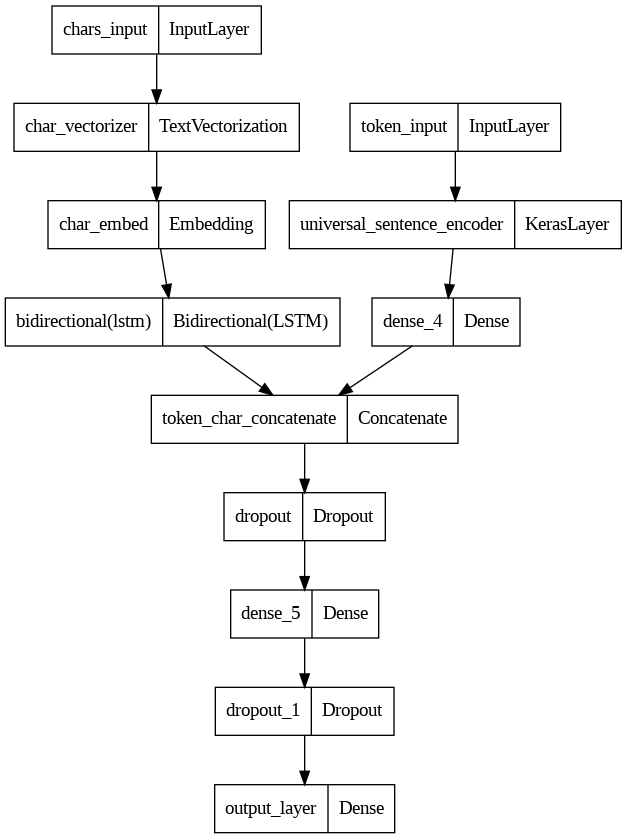

In [ ]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

Combining token and character data into a tf.data dataset

In [ ]:
# Combined token and chars into a dataset.
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

#  prefetche and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps for validation data.
valid_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
valid_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
valid_char_token_dataset = tf.data.Dataset.zip((valid_char_token_data, valid_char_token_labels))

valid_char_token_dataset = valid_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
# Check out training char and token embedding dataset
train_char_token_dataset, valid_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=len(train_char_token_dataset),
                              epochs=3,
                              validation_data=valid_char_token_dataset,
                              validation_steps=len(valid_char_token_dataset))


Epoch 1/3
69121/69121 [==============================] - 2053s 30ms/step - loss: 0.6308 - accuracy: 0.7648 - val_loss: 0.5242 - val_accuracy: 0.8046
Epoch 2/3
69121/69121 [==============================] - 2052s 30ms/step - loss: 0.5792 - accuracy: 0.7869 - val_loss: 0.5038 - val_accuracy: 0.8083
Epoch 3/3
69121/69121 [==============================] - 2050s 30ms/step - loss: 0.5649 - accuracy: 0.7928 - val_loss: 0.5003 - val_accuracy: 0.8136


In [ ]:
model_4.evaluate(valid_char_token_dataset)

905/905 [==============================] - 17s 19ms/step - loss: 0.5003 - accuracy: 0.8136


[0.5002684593200684, 0.8136319518089294]

In [ ]:
model_4_pred_probs = model_4.predict(valid_char_token_dataset)
model_4_pred_probs

905/905 [==============================] - 17s 17ms/step


array([[5.97052336e-01, 1.04197606e-01, 2.61564255e-02, 2.24508047e-01,
        4.80856039e-02],
       [2.72286814e-02, 1.14265624e-02, 8.33307862e-01, 2.55906954e-02,
        1.02446236e-01],
       [8.07308301e-04, 1.27733275e-01, 6.18251413e-03, 2.44137875e-04,
        8.65032792e-01],
       ...,
       [7.52487779e-03, 4.43869501e-01, 3.89030855e-03, 2.03381572e-03,
        5.42681456e-01],
       [1.37699377e-02, 2.55669117e-01, 1.79849397e-02, 3.96819133e-03,
        7.08607852e-01],
       [1.68313399e-01, 7.68529713e-01, 4.15436836e-04, 5.61227426e-02,
        6.61872094e-03]], dtype=float32)

In [ ]:
# Turn prediction probilities into classes.
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(28932,), dtype=int64, numpy=array([0, 2, 4, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds
                                    )

In [ ]:
model_4_results

{'accuracy': 81.36319646066639,
 'precision': 0.814533971777041,
 'recall': 0.8136319646066639,
 'f1': 0.8090238509110005}

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,74.975805,0.743197,0.749758,0.738957
custom_token_embed_conv1d,85.168671,0.851326,0.851687,0.850384
pretrained_token_embed,79.600442,0.795748,0.796004,0.793833
custom_char_embed_conv1d,78.231716,0.785873,0.782317,0.780126
hybrid_char_token_embed,81.363196,0.814534,0.813632,0.809024


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

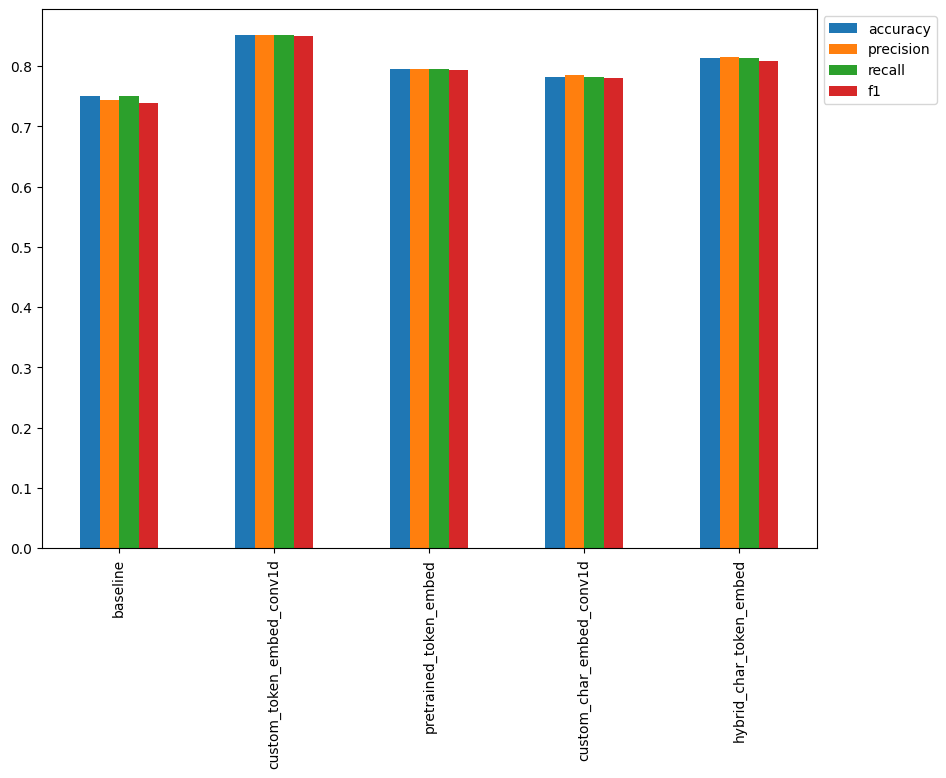

In [ ]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

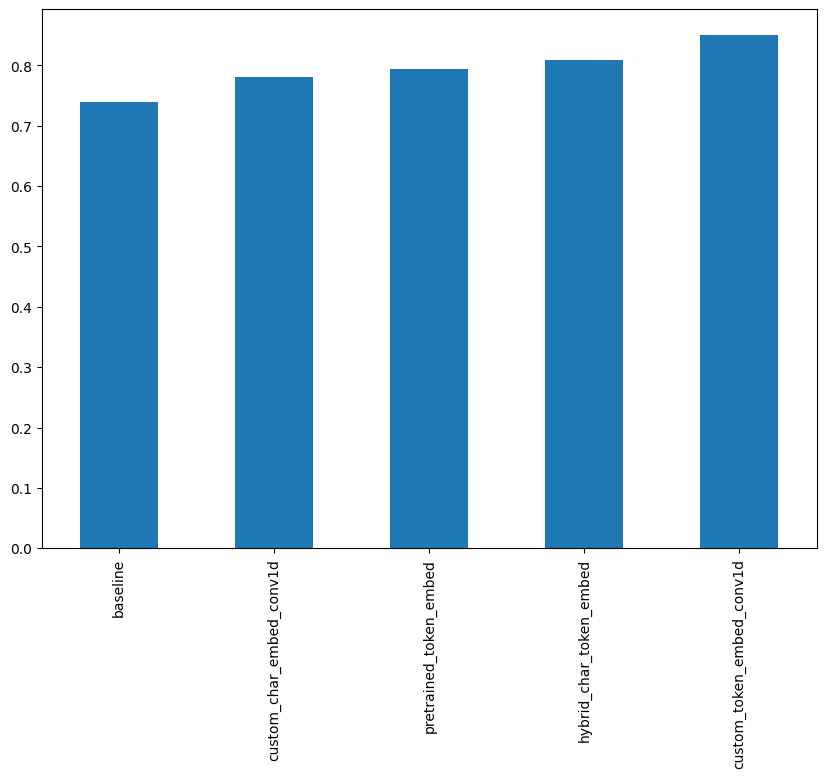

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7));